# PROGRAMACIÓN

In [2]:
import pandas as pd                     # Libreria para la manipulación y análisis de datos.
import numpy as np                      # Libreria para el manejo de vectores y matrices de grandes dimensiones.
import scipy.signal as signal           # Libreria para el procesamiento de señales.
import scipy.io as sio                  # Scipy es una libreria usada para cargar diferentes tipos de archivos.
import matplotlib.pyplot as plt         # Libreria para la generación de gráficos.
import glob

In [3]:
archivos_control = glob.glob('./control/*.mat') # Creación de lista en donde estan todos los archivos .mat de control
archivos_parkinson = glob.glob('./parkinson/*.mat')# Creación de lista en donde estan todos los archivos .mat de parkinson
print('Hay ' + str(len(archivos_control)) + ' sujetos de control')
print('Hay ' + str(len(archivos_parkinson)) + ' sujetos de parkinson')

Hay 36 sujetos de control
Hay 23 sujetos de parkinson


In [ ]:
prueba=sio.loadmat(archivos_control[0]); # Carga de datos de prueba, se carga el primer sujeto
data_c=prueba['data']# carga de solo los datos
data_control=data_c.copy() # creación de una copia 

In [ ]:
data_control.shape # Se tienen una señal de EEG de multiples canales y multiples epocas 

(8, 2000, 180)

In [ ]:
señal1=data_control[0][:,0]
señal1.shape

(2000, 180)

## 2. Crear una función que reciba dos señales de EEG y permita calcular el Coeficiente de coherencia

In [ ]:
range(len(señal1))==np.arange(0,2000)

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
# def fft(signal, ki=0, kf=2000):
#     N = len(signal)
#     freq = np.arange(ki, kf)
#     exp_factor = np.exp(-2*np.pi*1j*np.outer(np.arange(N), freq)/N)
#     coh = np.dot(signal, exp_factor)
#     return coh

In [ ]:
# def Calcular_Coherence(signal_EEG_1, signal_EEG_2, ki=0,kf=2000):
#     x=fft(signal_EEG_1,ki,kf)
#     y=fft(signal_EEG_2,ki,kf)
#     Sxx=(x*np.conj(x))/len(x)
#     Syy=(y*np.conj(y))/len(y)
#     Sxy=(x*np.conj(y))/len(x)
#     coh= np.abs(Sxy.real)/np.sqrt(Sxx.real*Syy.real)
#     return coh

In [ ]:
def Calcular_Coherence(signal_EEG_1, signal_EEG_2, ki=0,kf=2000):
    x=np.fft.fft(signal_EEG_1); x_conj=np.conjugate(x); fx=np.fft.fftfreq(len(x),1/len(signal_EEG_1))
    y=np.fft.fft(signal_EEG_2); y_conj=np.conjugate(y);
    freqint= (fx >=ki)&(fx<=kf)
    Sxx=(x[freqint]*x_conj[freqint])
    Syy=(y[freqint]*y_conj[freqint])
    Sxy=(x[freqint]*y_conj[freqint])
    coh=np.abs(np.mean(Sxy.real))/np.sqrt(np.mean(Sxx.real)*np.mean(Syy.real))
#     coh= np.abs(Sxy.real)/np.sqrt(Sxx.real*Syy.real)
    return coh

In [ ]:
x = [4,2,7,4,5]
y = [4,2,3,4,5]

In [ ]:
a=np.fft.fft(señal1)

frecuencias= np.fft.fftfreq(len(a),d=1/2000)

interestfreq= (frecuencias >=26)&(frecuencias<=60)

coh= a[interestfreq]
coh.shape

(35,)

In [ ]:
Calcular_Coherence(x,y,0,5)

0.9654834289083339

## 3. Crear una función que reciba una señal EEG de múltiples canales y múltiples épocas y devuelva la sumatoria del coeficiente de coherencia en el rango de frecuencia de 13 a 30 Hz para las diferentes combinaciones de pares de canales. Almacenar los resultados en una matriz donde la entrada (i,j) tiene la coherencia del canal i con el canal j


In [ ]:
data_control.shape

(8, 2000, 180)

In [ ]:
n_channels, n_samples, n_epochs = data_control.shape


(8, 2000, 180)

In [ ]:
data_control[1][2].shape

(180,)

In [ ]:
def coherence_multichannel(data_control):
    n_channels, n_samples, n_epochs = data_control.shape
    cohe_matrix = np.zeros((n_channels, n_channels))
    csd=[]
    for i in range(n_channels):
        for j in range(i, n_channels):
            cohe_channel = []
            for k in range(n_epochs):
                cohe_channel.append(Calcular_Coherence(data_control[i, :, k], data_control[j, :, k],26 , 60))
            cohe_sum=np.sum(cohe_channel)
            cohe_matrix[i, j] = (cohe_sum/n_epochs)*35
            cohe_matrix[j, i] = (cohe_sum/n_epochs)*35
        csd.append(np.mean(cohe_matrix[i]))
    return cohe_matrix,csd

In [ ]:
cohematrix,csd=coherence_multichannel(data_control)
cohematrix

array([[35.        , 26.94335654,  9.5180746 ,  7.56109072, 16.12399781,
         4.20701358,  7.7196486 , 11.7201888 ],
       [26.94335654, 35.        , 25.73913578,  7.12970957,  8.04078461,
         8.46742806, 12.48634085, 14.65318628],
       [ 9.5180746 , 25.73913578, 35.        , 22.70865216,  7.1355095 ,
        13.09290126, 14.72699909, 14.070947  ],
       [ 7.56109072,  7.12970957, 22.70865216, 35.        , 27.24004176,
        14.33790803, 13.08037226,  9.34139804],
       [16.12399781,  8.04078461,  7.1355095 , 27.24004176, 35.        ,
        12.2762024 ,  8.99417518,  4.73946278],
       [ 4.20701358,  8.46742806, 13.09290126, 14.33790803, 12.2762024 ,
        35.        , 32.07181769, 19.4814719 ],
       [ 7.7196486 , 12.48634085, 14.72699909, 13.08037226,  8.99417518,
        32.07181769, 35.        , 27.5610194 ],
       [11.7201888 , 14.65318628, 14.070947  ,  9.34139804,  4.73946278,
        19.4814719 , 27.5610194 , 35.        ]])

In [ ]:
pd.DataFrame(cohematrix)


,0,1,2,3,4,5,6,7
0,35.000000,26.943357,9.518075,7.561091,16.123998,4.207014,7.719649,11.720189
1,26.943357,35.000000,25.739136,7.129710,8.040785,8.467428,12.486341,14.653186
2,9.518075,25.739136,35.000000,22.708652,7.135509,13.092901,14.726999,14.070947
3,7.561091,7.129710,22.708652,35.000000,27.240042,14.337908,13.080372,9.341398
4,16.123998,8.040785,7.135509,27.240042,35.000000,12.276202,8.994175,4.739463
5,4.207014,8.467428,13.092901,14.337908,12.276202,35.000000,32.071818,19.481472
6,7.719649,12.486341,14.726999,13.080372,8.994175,32.071818,35.000000,27.561019
7,11.720189,14.653186,14.070947,9.341398,4.739463,19.481472,27.561019,35.000000


In [ ]:
coherence_multichannel(data_control)

(array([[35.        , 26.94335654,  9.5180746 ,  7.56109072, 16.12399781,
          4.20701358,  7.7196486 , 11.7201888 ],
        [26.94335654, 35.        , 25.73913578,  7.12970957,  8.04078461,
          8.46742806, 12.48634085, 14.65318628],
        [ 9.5180746 , 25.73913578, 35.        , 22.70865216,  7.1355095 ,
         13.09290126, 14.72699909, 14.070947  ],
        [ 7.56109072,  7.12970957, 22.70865216, 35.        , 27.24004176,
         14.33790803, 13.08037226,  9.34139804],
        [16.12399781,  8.04078461,  7.1355095 , 27.24004176, 35.        ,
         12.2762024 ,  8.99417518,  4.73946278],
        [ 4.20701358,  8.46742806, 13.09290126, 14.33790803, 12.2762024 ,
         35.        , 32.07181769, 19.4814719 ],
        [ 7.7196486 , 12.48634085, 14.72699909, 13.08037226,  8.99417518,
         32.07181769, 35.        , 27.5610194 ],
        [11.7201888 , 14.65318628, 14.070947  ,  9.34139804,  4.73946278,
         19.4814719 , 27.5610194 , 35.        ]]),
 [14.849171333

## 4. Crear una rutina que aplique sobre todos los archivos de la base de datos la rutina de coeficiente de coherencia del punto anterior y almacene los promedios de coherencia de cada canal, calculados como el promedio sobre las filas o columnas de la matriz anterior, en un dataframe donde se pueda discriminar nombre sujeto, control o paciente.

In [ ]:
archivos_TOTAL= []
archivos_TOTAL.extend(archivos_control),archivos_TOTAL.extend(archivos_parkinson)
archivos_TOTAL # Se unen todas las rutas de los archivos .mat en una sola

['./control\\C001R_EP_reposo.mat',
 './control\\C002_EP_reposo.mat',
 './control\\C004_EP_reposo.mat',
 './control\\C005_EP_reposo_Repetido.mat',
 './control\\C006_EP_reposo.mat',
 './control\\C007_EP_reposo.mat',
 './control\\C010_EP_reposo.mat',
 './control\\C011_EP_reposo.mat',
 './control\\C012_EP_reposo.mat',
 './control\\C013_EP_reposo.mat',
 './control\\C015_EP_reposo.mat',
 './control\\C018_EP_reposo.mat',
 './control\\C019_EP_reposo.mat',
 './control\\C020_EP_reposo.mat',
 './control\\C021_EP_reposo.mat',
 './control\\C023_EP_reposo.mat',
 './control\\C024_EP_reposo.mat',
 './control\\C025_EP_reposo.mat',
 './control\\C026_EP_reposo.mat',
 './control\\C027_EP_reposo.mat',
 './control\\C028_EP_reposo.mat',
 './control\\C029_EP_reposo.mat',
 './control\\C030_EP_reposo.mat',
 './control\\C031_EP_reposo.mat',
 './control\\C032_EP_reposo.mat',
 './control\\C033R_EP_reposo.mat',
 './control\\C034_EP_reposo.mat',
 './control\\C036_EP_reposo.mat',
 './control\\C037_EP_reposo.mat',
 '.

In [ ]:
estados=[]
results=[]
for archivo in archivos_TOTAL: #RECORRE TODOS LOS ARCHIVOS DE LA LISTA ANTERIOR 
    estado=archivo.split("/")[1].split("\\")[0] # Estado de los pacientes 
    estados.append(estado)
    mat_contents = sio.loadmat(archivo)
    data_original = mat_contents['data'];
    data = data_original.copy()
    cohe_matrix ,csd= coherence_multichannel(data)
    results.append(csd)

In [ ]:
columnas=['Coherencia promedio Canal C3 ','Coherencia promedio Canal C1 ','Coherencia promedio Canal CZ ','Coherencia promedio Canal C2 ','Coherencia promedio Canal C4 ','Coherencia promedio Canal O1 ','Coherencia promedio Canal OZ ','Coherencia promedio Canal O2 ']
df_pacientes=pd.DataFrame(results)
df_pacientes.index = np.arange(1, len(df_pacientes)+1) #El index comienza desde 1
df_pacientes.index.names = ['#sujeto']
df_pacientes.columns = columnas
df_pacientes.insert(0,"Estado",estados) #Se inserta la columna "Estado"
df_pacientes

,Estado,Coherencia promedio Canal C3,Coherencia promedio Canal C1,Coherencia promedio Canal CZ,Coherencia promedio Canal C2,Coherencia promedio Canal C4,Coherencia promedio Canal O1,Coherencia promedio Canal OZ,Coherencia promedio Canal O2
#sujeto,,,,,,,,,
1,control,14.849171,17.307493,17.749027,17.049897,14.943772,17.366843,18.955047,17.070959
2,control,16.924653,21.032542,22.422579,21.300100,17.725121,21.930761,23.546733,21.994992
3,control,21.315409,22.923320,22.315416,21.714691,22.282868,19.007516,21.135489,20.351065
4,control,16.192949,20.066584,20.504994,19.728608,15.033686,19.948875,21.382135,20.130074
5,control,17.046709,20.125907,20.882691,18.974740,15.526267,19.430396,21.188881,19.242761
6,control,14.434536,16.805586,17.624164,17.224124,14.714976,17.262719,18.479666,17.576158
7,control,16.044174,21.123503,22.291134,21.362897,15.557636,22.331682,19.356610,21.242210
8,control,15.294404,17.455201,17.757400,17.505602,15.010701,16.630841,18.830167,17.103223
9,control,16.998915,22.478266,23.486355,22.314800,18.072323,21.175421,22.817477,21.208136


In [ ]:
df_pacientes.to_csv("TabladeResultados.csv",index=False) # Se exporta el dataframe como un archivo.csv para trabajar con mayor facilidad 

## 5. Crear una rutina que aplique sobre todos los archivos de la base de datos la rutina de densidad espectral de potencia, usando la rutina de Welch, y almacene los resultados en un dataframe donde se pueda discriminar nombre sujeto, control o paciente y la sumatoria de densidad espectral de potencia para cada canal en el rango 13-30

In [ ]:
from scipy.signal import welch as pwelch
def compute_psd(señal):
    fmin = 13 # Hz
    fmax = 30 # Hz
    fs= 1000
    nperseg= 2000
    noverlap= int(nperseg/2)
    f, pxx = pwelch(señal, fs, 'hann', nperseg, noverlap)
    psd = pxx[np.where((f >= fmin) & (f <= fmax))]
    return psd

def welch_multichannel(data):
    n_channels, n_samples, n_epochs = data.shape
    s_channels=[]
    mean_psd=[]
    sumatoria=[]
    for i in range(n_channels):
        for j in range(n_epochs):
            psds= compute_psd(data[i,:,j])
            s_channels.append(psds)
        mean= np.mean(s_channels,axis=0)
        mean_psd.append(mean)
        suma= np.sum(mean)        
        sumatoria.append(suma)
    return mean_psd, sumatoria  

In [ ]:
psd_results = []
for archivo in archivos_TOTAL: #RECORRE TODOS LOS ARCHIVOS DE LA LISTA ANTERIOR 
    mat_contents = sio.loadmat(archivo)
    data_original = mat_contents['data'];
    data = data_original.copy()
    psd_mean,psd_sum= welch_multichannel(data)
    psd_results.append(psd_sum)

In [ ]:
df_PSD=pd.DataFrame(psd_results)
df_PSD.index = np.arange(1, len(df_pacientes)+1) #El index comienza desde 1
df_PSD.index.names = ['#sujeto']
df_PSD.columns = ['PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2']
df_PSD.insert(0,"Estado",estados) #Se inserta la columna "Estado"
df_PSD

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
#sujeto,,,,,,,,,
1,control,8.816652,8.425719,8.269976,7.992523,7.977260,8.270010,8.200905,8.351388
2,control,4.418235,4.427389,4.725075,4.912008,4.952694,6.607816,7.240721,7.817121
3,control,4.571503,3.943930,4.477583,4.018325,4.325851,4.153628,4.056005,4.148277
4,control,11.354676,9.840373,9.411914,9.258043,9.835680,11.194962,12.014723,12.796685
5,control,7.588519,7.650962,7.696368,7.859726,8.071986,8.894458,8.995551,9.187608
6,control,5.022228,4.525979,4.625264,4.543834,4.607184,4.769203,4.877122,5.092292
7,control,4.199473,4.148189,4.336296,4.261814,4.301784,4.453306,4.406512,4.683015
8,control,5.652386,4.682482,4.433387,4.301514,4.781788,5.340131,5.466576,5.691624
9,control,1.892841,1.816382,1.882840,1.883181,1.915498,3.057755,3.851434,4.501363


In [ ]:
df_PSD.to_csv("TabladeResultadosPSD.csv",index=False) # Se exporta el dataframe como un archivo.csv para trabajar con mayor facilidad

# ESTADISTICA

## Estadistica para el coeficiente de coherencia 

In [4]:
df= pd.read_csv("TabladeResultados.csv") #Se importa el archivo con los datos
print(df.head(),df.info()) # Se corrobora la información 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Estado                         59 non-null     object 
 1   Coherencia promedio Canal C3   59 non-null     float64
 2   Coherencia promedio Canal C1   59 non-null     float64
 3   Coherencia promedio Canal CZ   59 non-null     float64
 4   Coherencia promedio Canal C2   59 non-null     float64
 5   Coherencia promedio Canal C4   59 non-null     float64
 6   Coherencia promedio Canal O1   59 non-null     float64
 7   Coherencia promedio Canal OZ   59 non-null     float64
 8   Coherencia promedio Canal O2   59 non-null     float64
dtypes: float64(8), object(1)
memory usage: 4.3+ KB
    Estado  Coherencia promedio Canal C3   Coherencia promedio Canal C1   \
0  control                      14.849171                      17.307493   
1  control                      16

In [5]:
df_control=df[df['Estado'] == 'control'] # Se definen los pacientes de control
df_parkinson = df[df['Estado'] == 'parkinson'] # Se definen los pacientes de parkinson

In [6]:
# Como el dataframe de los grupos contiene una columna tipo str se elimina en una copia del df para poder calcular la mediana
df_controlC= df_control.copy()
df_controlC= df_controlC.drop(['Estado'],axis=1)

df_parkinsonC= df_parkinson.copy()
df_parkinsonC=df_parkinsonC.drop(['Estado'],axis=1)

In [16]:
def graficar(control, parkinson, estadistica): # Toma los datos de control, parkinson y la prueba estadistica 
    labels = ['C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2']
    fig, ax = plt.subplots()
    width = 0.35  # the width of the bars
    x = np.arange(len(labels))

    # Definición de los valores de las barras 
    rects1 = ax.bar(x - width/2, control, width, label='Control')
    rects2 = ax.bar(x + width/2, parkinson, width, label='Parkinson')

    # Definición de las barras de error
    errors1 = np.std(control)
    errors2 = np.std(parkinson)

    ax.errorbar(x - width/2, control, yerr=errors1, fmt='none', capsize=5, color='red')
    ax.errorbar(x + width/2, parkinson, yerr=errors2, fmt='none', capsize=5, color='red')

    ax.set_xticks(x) # Se establecen los limites del eje 
    ax.set_xticklabels(labels)
    fig.tight_layout()
    ax.set_ylabel(str(estadistica)+' coeficiente de coherencia') # concatena el nombre de la prueba estadistica con el eje Y
    ax.set_xlabel('Canales')
    ax.set_title(str(estadistica)+' del coeficiente de coherencia para cada grupo en cada canal') # Concatena el nombre de la prueba estadistica con el titulo de la figura 
    ax.legend(loc="center") # Localización de la leyenda 

    plt.show()

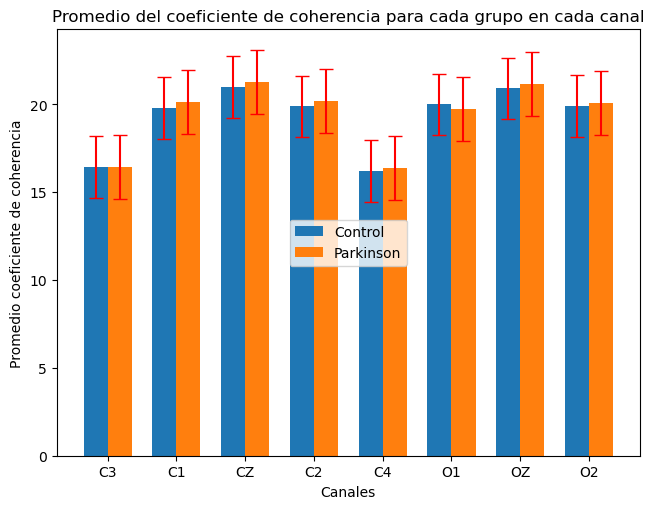

---------------------------------------

 Promedio coeficiente de coherencia Grupo Control 


Coherencia promedio Canal C3     16.408569
Coherencia promedio Canal C1     19.768701
Coherencia promedio Canal CZ     20.988147
Coherencia promedio Canal C2     19.874280
Coherencia promedio Canal C4     16.201695
Coherencia promedio Canal O1     19.987822
Coherencia promedio Canal OZ     20.895221
Coherencia promedio Canal O2     19.894613
dtype: float64
---------------------------------------

 Promedio coeficiente de coherencia Grupo Parkinson 


Coherencia promedio Canal C3     16.407478
Coherencia promedio Canal C1     20.104852
Coherencia promedio Canal CZ     21.277882
Coherencia promedio Canal C2     20.194544
Coherencia promedio Canal C4     16.362809
Coherencia promedio Canal O1     19.725953
Coherencia promedio Canal OZ     21.172710
Coherencia promedio Canal O2     20.050725
dtype: float64


In [18]:
"la PSD es una medida de la actividad cerebral en términos de contenido de frecuencia. El promedio de la PSD se puede utilizar para identificar patrones de actividad cerebral"
promedio_control,promedio_parkinson= np.mean(df_control),np.mean(df_parkinson)
graficar(promedio_control,promedio_parkinson,'Promedio')

print('---------------------------------------\n\n Promedio coeficiente de coherencia Grupo Control \n\n')
print(promedio_control)
print('---------------------------------------\n\n Promedio coeficiente de coherencia Grupo Parkinson \n\n')
print(promedio_parkinson)

El coeficiente de coherencia se basa en el análisis de la potencia espectral cruzada entre dos señales EEG en diferentes frecuencias. Este análisis permite identificar si la actividad cerebral de dos regiones cerebrales está sincronizada en una determinada frecuencia, lo que indica una posible conexión funcional entre dichas regiones.

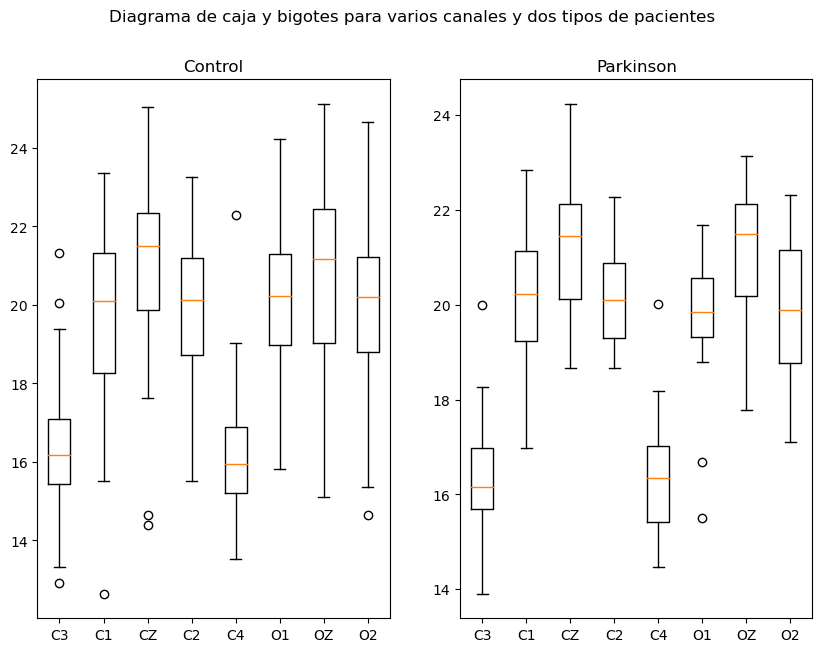

In [7]:
"Un diagrama de cajas y bigotes muestra la distribución de los valores de los valores del coeficiente de coherencia para cada canal en términos de cuartiles y valores extremos, lo que puede permitir una comparación visual de la actividad cerebral en diferentes regiones del cerebro."
dataframes = [df_controlC,df_parkinsonC] # Se unifican los dataframes

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']
labels1=['C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2']
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,7))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['Coherencia promedio Canal C3 '], df_estado['Coherencia promedio Canal C1 '], df_estado['Coherencia promedio Canal CZ '], df_estado['Coherencia promedio Canal C2 '], df_estado['Coherencia promedio Canal C4 '], df_estado['Coherencia promedio Canal O1 '], df_estado['Coherencia promedio Canal OZ '], df_estado['Coherencia promedio Canal O2 ']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

## Estadistica para la densidad espectral de potencia usando la rutina de Welch

In [12]:
dfPSD= pd.read_csv("TabladeResultadosPSD.csv") #Se importa el archivo con los datos
print(dfPSD.head(),dfPSD.info()) # Se corrobora la información 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Estado  59 non-null     object 
 1   PSD_C3  59 non-null     float64
 2   PSD_C1  59 non-null     float64
 3   PSD_CZ  59 non-null     float64
 4   PSD_C2  59 non-null     float64
 5   PSD_C4  59 non-null     float64
 6   PSD_O1  59 non-null     float64
 7   PSD_OZ  59 non-null     float64
 8   PSD_O2  59 non-null     float64
dtypes: float64(8), object(1)
memory usage: 4.3+ KB
    Estado     PSD_C3    PSD_C1    PSD_CZ    PSD_C2    PSD_C4     PSD_O1  \
0  control   8.816652  8.425719  8.269976  7.992523  7.977260   8.270010   
1  control   4.418235  4.427389  4.725075  4.912008  4.952694   6.607816   
2  control   4.571503  3.943930  4.477583  4.018325  4.325851   4.153628   
3  control  11.354676  9.840373  9.411914  9.258043  9.835680  11.194962   
4  control   7.588519  7.650962  7.696368  7.859726  8.0719

In [13]:
df_controlPSD=dfPSD[dfPSD['Estado'] == 'control'] # Se definen los pacientes de control
df_parkinsonPSD = dfPSD[dfPSD['Estado'] == 'parkinson'] # Se definen los pacientes de parkinson
# Como el dataframe de los grupos contiene una columna tipo str se elimina en una copia del df para poder calcular la mediana
df_controlPSDC= df_controlPSD.copy();df_controlPSDC= df_controlPSDC.drop(['Estado'],axis=1)

df_parkinsonPSDC= df_parkinsonPSD.copy();df_parkinsonPSDC=df_parkinsonPSDC.drop(['Estado'],axis=1)

C:\Users\Esteban\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\Esteban\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


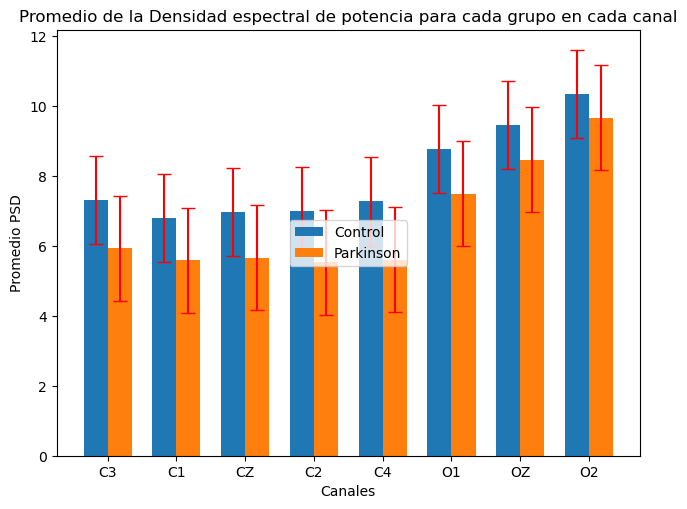

---------------------------------------

 Promedio PSD Grupo Control 


PSD_C3     7.319505
PSD_C1     6.798453
PSD_CZ     6.962428
PSD_C2     6.988998
PSD_C4     7.263738
PSD_O1     8.753182
PSD_OZ     9.454501
PSD_O2    10.329982
dtype: float64
---------------------------------------

 Promedio PSD Grupo Parkinson 


PSD_C3    5.927973
PSD_C1    5.585441
PSD_CZ    5.651272
PSD_C2    5.521172
PSD_C4    5.599444
PSD_O1    7.484487
PSD_OZ    8.453296
PSD_O2    9.661973
dtype: float64


In [14]:
"la PSD es una medida de la actividad cerebral en términos de contenido de frecuencia. El promedio de la PSD se puede utilizar para identificar patrones de actividad cerebral"
promedio_control,promedio_parkinson= np.mean(df_controlPSD),np.mean(df_parkinsonPSD)
graficar(promedio_control,promedio_parkinson,'Promedio')

print('---------------------------------------\n\n Promedio PSD Grupo Control \n\n')
print(promedio_control)
print('---------------------------------------\n\n Promedio PSD Grupo Parkinson \n\n')
print(promedio_parkinson)

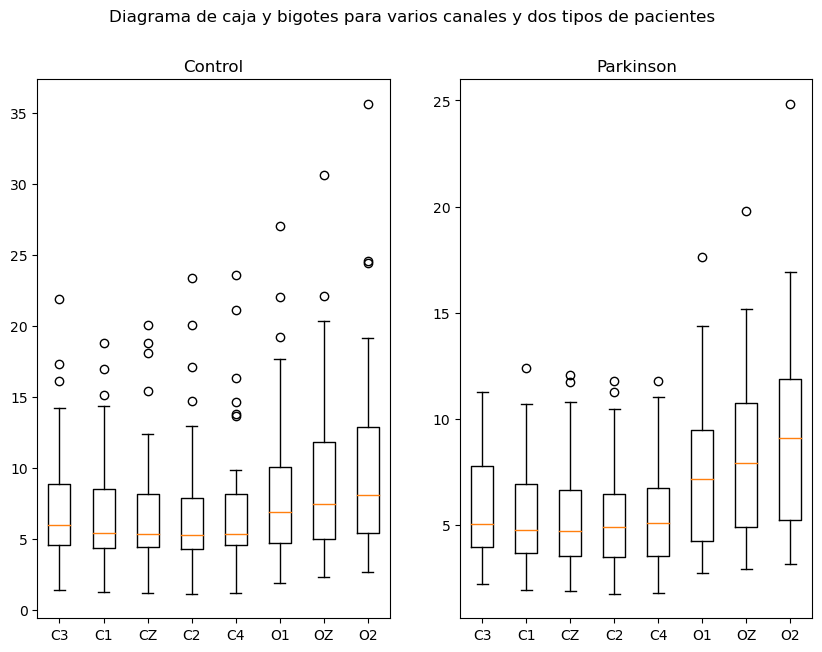

In [10]:
"Un diagrama de cajas y bigotes muestra la distribución de los valores de los valores del coeficiente de coherencia para cada canal en términos de cuartiles y valores extremos, lo que puede permitir una comparación visual de la actividad cerebral en diferentes regiones del cerebro."
dataframes = [df_controlPSDC,df_parkinsonPSDC] # Se unifican los dataframes

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']
labels1=['C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2']
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,7))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

# PRUEBAS DE HIPOTESIS


In [22]:
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind

## Pruebas de hipotesis para el coeficiente de coherencia 

### Pruebas de normalidad

 * Prueba de normalidad shapiro para pacientes de control

In [31]:
p_values={}
alpha_shapiro_ct = 0.05
for col in df_controlC.columns: #Para cada columna presente en el dataframe de control
    stat, p = shapiro(list(df_controlC[col])) #Implementación de la prueba Shapiro-Wilk
    print(f'Grupo de control - {col}: Estadístico de prueba={stat:.3f}, p={p:.3f}')
    if p > alpha_shapiro_ct:
        print(f'Los datos del coeficiente de {col} del grupo de control parecen seguir una distribución normal (no se puede rechazar la hipótesis nula)\n')
        p_values[col]=p

    else:
        print(f'Los datos del coeficiente de {col} del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)\n')
print('--------------------------------------------------------------------------------------------')
print('Los siguientes canales corresponden a aquellos que parecen seguir una distribución normal')
df_coherencias = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_coherencias

Grupo de control - Coherencia promedio Canal C3 : Estadístico de prueba=0.953, p=0.129
Los datos del coeficiente de Coherencia promedio Canal C3  del grupo de control parecen seguir una distribución normal (no se puede rechazar la hipótesis nula)

Grupo de control - Coherencia promedio Canal C1 : Estadístico de prueba=0.943, p=0.064
Los datos del coeficiente de Coherencia promedio Canal C1  del grupo de control parecen seguir una distribución normal (no se puede rechazar la hipótesis nula)

Grupo de control - Coherencia promedio Canal CZ : Estadístico de prueba=0.939, p=0.046
Los datos del coeficiente de Coherencia promedio Canal CZ  del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)

Grupo de control - Coherencia promedio Canal C2 : Estadístico de prueba=0.979, p=0.698
Los datos del coeficiente de Coherencia promedio Canal C2  del grupo de control parecen seguir una distribución normal (no se puede rechazar la hipótesis nula)

Grupo de contro

,Valor P
Coherencia promedio Canal C3,0.128930
Coherencia promedio Canal C1,0.063610
Coherencia promedio Canal C2,0.697919
Coherencia promedio Canal O1,0.490911
Coherencia promedio Canal OZ,0.350531
Coherencia promedio Canal O2,0.615237


 * Prueba de normalidad shapiro para pacientes con parkinson

In [24]:
p_values={}
alpha_shapiro_ct = 0.05
for col in df_parkinsonC.columns: #Para cada columna presente en el dataframe de control
    stat, p = shapiro(list(df_parkinsonC[col])) #Implementación de la prueba Shapiro-Wilk
    print(f'Grupo de control - {col}: Estadístico de prueba={stat:.3f}, p={p:.3f}')
    if p > alpha_shapiro_ct:
        print(f'Los datos del coeficiente de {col} del grupo de control parecen seguir una distribución normal (no se puede rechazar la hipótesis nula)\n')
        p_values[col]=p

    else:
        print(f'Los datos del coeficiente de {col} del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)\n')
print('--------------------------------------------------------------------------------------------')
print('Los siguientes canales corresponden a aquellos que parecen seguir una distribución normal')
df_coherenciasp = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_coherenciasp

Grupo de control - Coherencia promedio Canal C3 : Estadístico de prueba=0.964, p=0.541
Los datos del coeficiente de Coherencia promedio Canal C3  del grupo de control parecen seguir una distribución normal (no se puede rechazar la hipótesis nula)

Grupo de control - Coherencia promedio Canal C1 : Estadístico de prueba=0.979, p=0.896
Los datos del coeficiente de Coherencia promedio Canal C1  del grupo de control parecen seguir una distribución normal (no se puede rechazar la hipótesis nula)

Grupo de control - Coherencia promedio Canal CZ : Estadístico de prueba=0.976, p=0.819
Los datos del coeficiente de Coherencia promedio Canal CZ  del grupo de control parecen seguir una distribución normal (no se puede rechazar la hipótesis nula)

Grupo de control - Coherencia promedio Canal C2 : Estadístico de prueba=0.949, p=0.276
Los datos del coeficiente de Coherencia promedio Canal C2  del grupo de control parecen seguir una distribución normal (no se puede rechazar la hipótesis nula)

Grupo de

,Valor P
Coherencia promedio Canal C3,0.541312
Coherencia promedio Canal C1,0.895722
Coherencia promedio Canal CZ,0.819192
Coherencia promedio Canal C2,0.275933
Coherencia promedio Canal C4,0.275444
Coherencia promedio Canal OZ,0.371101
Coherencia promedio Canal O2,0.488542


Solo el canal O1 no sigue una distribución normal. Por lo tanto es posible continuar con la prueba de homocedasticidad para cada par de canales

### Pruebas de homocedasticidad

In [25]:
p_values={}
alpha_levene = 0.05
for col in df_coherencias.index:
    stat, p = levene(list(df_controlC[col]), list(df_parkinsonC[col]))#Implementación de la prueba levene
    print(f'Canal {col}: Estadístico de prueba={stat:.3f}, p={p:.3f}')
    if p > alpha_levene:
        print(f'Las varianzas de los canales {col} parecen ser constantes entre los grupos (no se puede rechazar la hipótesis nula)\n')
        p_values[col]=p
    else:
        print(f'Las varianzas de los canales {col} no parecen ser constantes entre los grupos (se rechaza la hipótesis nula)\n')
print('--------------------------------------------------------------------------------------------')
print('Los siguientes canales corresponden a aquellos que parecen ser constantes entre los grupos')
df_coherenciasp = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_coherenciasp

Canal Coherencia promedio Canal C3 : Estadístico de prueba=0.590, p=0.445
Las varianzas de los canales Coherencia promedio Canal C3  parecen ser constantes entre los grupos (no se puede rechazar la hipótesis nula)

Canal Coherencia promedio Canal C1 : Estadístico de prueba=3.245, p=0.077
Las varianzas de los canales Coherencia promedio Canal C1  parecen ser constantes entre los grupos (no se puede rechazar la hipótesis nula)

Canal Coherencia promedio Canal C2 : Estadístico de prueba=4.282, p=0.043
Las varianzas de los canales Coherencia promedio Canal C2  no parecen ser constantes entre los grupos (se rechaza la hipótesis nula)

Canal Coherencia promedio Canal O1 : Estadístico de prueba=5.221, p=0.026
Las varianzas de los canales Coherencia promedio Canal O1  no parecen ser constantes entre los grupos (se rechaza la hipótesis nula)

Canal Coherencia promedio Canal OZ : Estadístico de prueba=5.128, p=0.027
Las varianzas de los canales Coherencia promedio Canal OZ  no parecen ser consta

,Valor P
Coherencia promedio Canal C3,0.445402
Coherencia promedio Canal C1,0.076926
Coherencia promedio Canal O2,0.089608


Solo el canal C3, C1 y O2 cumplen con el criterio para hacer la prueba t

### Prueba T

In [26]:
p_values={}
alpha_t = 0.05
for col in df_coherenciasp.index:
    stat, p = ttest_ind(list(df_controlC[col]), list(df_parkinsonC[col]), alternative='two-sided')#Implementación de la prueba U de Mann-Whitney
    print(f'Canal {col}: Estadístico U={stat:.3f}, p={p:.3f}')
    if p > alpha_t:
        print(f'No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
        p_values[col]=p
    else:
        print(f'Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
print('--------------------------------------------------------------------------------------------')
print('Los siguientes canales corresponden a aquellos que son iguales estadisticamente')
df_coherenciast = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_coherenciast

Canal Coherencia promedio Canal C3 : Estadístico U=0.003, p=0.998
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal Coherencia promedio Canal C3  de ambos grupos.

Canal Coherencia promedio Canal C1 : Estadístico U=-0.607, p=0.546
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal Coherencia promedio Canal C1  de ambos grupos.

Canal Coherencia promedio Canal O2 : Estadístico U=-0.278, p=0.782
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal Coherencia promedio Canal O2  de ambos grupos.



,Valor P
Coherencia promedio Canal C3,0.997958
Coherencia promedio Canal C1,0.546239
Coherencia promedio Canal O2,0.782333


### Prueba U

Como se observa anteriormente, solo 3 canales cumplen con los criterios para realizarse una prueba T, por lo tanto con los otros canales se procede a evaluarse con la prueba de U de mann whitney

In [39]:
df_no=df_controlC.drop(columns=df_coherenciasp.index)

In [38]:
p_values={}
alpha_u = 0.05
for col in df_no.columns:
    stat, p = mannwhitneyu(list(df_controlC[col]), list(df_parkinsonC[col]), alternative='two-sided')#Implementación de la prueba U de Mann-Whitney
    print(f'Canal {col}: Estadístico U={stat:.3f}, p={p:.3f}')
    if p > alpha_u:
        print(f'No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
        p_values[col]=p
    else:
        print(f'Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
print('--------------------------------------------------------------------------------------------')
print('Los siguientes canales corresponden a aquellos que son iguales estadisticamente')
df_cohe = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_cohe

Canal Coherencia promedio Canal CZ : Estadístico U=413.000, p=0.994
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal Coherencia promedio Canal CZ  de ambos grupos.

Canal Coherencia promedio Canal C2 : Estadístico U=395.000, p=0.774
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal Coherencia promedio Canal C2  de ambos grupos.

Canal Coherencia promedio Canal C4 : Estadístico U=368.000, p=0.479
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal Coherencia promedio Canal C4  de ambos grupos.

Canal Coherencia promedio Canal O1 : Estadístico U=453.000, p=0.550
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal Coherencia promedio Canal O1  de ambos grupos.

Canal Coherencia promedio Canal OZ : Estadístico U=392.000, p=0.738
No se puede rechazar la hipótesis nula de que no

,Valor P
Coherencia promedio Canal CZ,0.993800
Coherencia promedio Canal C2,0.773712
Coherencia promedio Canal C4,0.479474
Coherencia promedio Canal O1,0.549602
Coherencia promedio Canal OZ,0.738268


## Pruebas de hipotesis para la PSD utilizando la rutina de Welch

### Pruebas de normalidad

In [41]:
p_values={}
alpha_shapiro_ct = 0.05
for col in df_controlPSDC.columns: #Para cada columna presente en el dataframe de control
    stat, p = shapiro(list(df_controlPSDC[col])) #Implementación de la prueba Shapiro-Wilk
    print(f'Grupo de control - {col}: Estadístico de prueba={stat:.3f}, p={p:.3f}')
    if p > alpha_shapiro_ct:
        print(f'Los datos del coeficiente de {col} del grupo de control parecen seguir una distribución normal (no se puede rechazar la hipótesis nula)\n')
        p_values[col]=p

    else:
        print(f'Los datos del coeficiente de {col} del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)\n')
print('--------------------------------------------------------------------------------------------')
print('Los siguientes canales corresponden a aquellos que parecen seguir una distribución normal')
df_coherencias = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_coherencias

Grupo de control - PSD_C3: Estadístico de prueba=0.869, p=0.001
Los datos del coeficiente de PSD_C3 del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)

Grupo de control - PSD_C1: Estadístico de prueba=0.875, p=0.001
Los datos del coeficiente de PSD_C1 del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)

Grupo de control - PSD_CZ: Estadístico de prueba=0.835, p=0.000
Los datos del coeficiente de PSD_CZ del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)

Grupo de control - PSD_C2: Estadístico de prueba=0.822, p=0.000
Los datos del coeficiente de PSD_C2 del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)

Grupo de control - PSD_C4: Estadístico de prueba=0.827, p=0.000
Los datos del coeficiente de PSD_C4 del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)

Grupo de control - PSD_O1

,Valor P


* Prueba de normalidad para los pacientes con parkinson

In [42]:
p_values={}
alpha_shapiro_ct = 0.05
for col in df_parkinsonPSDC.columns: #Para cada columna presente en el dataframe de control
    stat, p = shapiro(list(df_parkinsonPSDC[col])) #Implementación de la prueba Shapiro-Wilk
    print(f'Grupo de control - {col}: Estadístico de prueba={stat:.3f}, p={p:.3f}')
    if p > alpha_shapiro_ct:
        print(f'Los datos del coeficiente de {col} del grupo de control parecen seguir una distribución normal (no se puede rechazar la hipótesis nula)\n')
        p_values[col]=p

    else:
        print(f'Los datos del coeficiente de {col} del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)\n')
print('--------------------------------------------------------------------------------------------')
print('Los siguientes canales corresponden a aquellos que parecen seguir una distribución normal')
df_coherencias = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_coherencias

Grupo de control - PSD_C3: Estadístico de prueba=0.913, p=0.047
Los datos del coeficiente de PSD_C3 del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)

Grupo de control - PSD_C1: Estadístico de prueba=0.907, p=0.036
Los datos del coeficiente de PSD_C1 del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)

Grupo de control - PSD_CZ: Estadístico de prueba=0.883, p=0.011
Los datos del coeficiente de PSD_CZ del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)

Grupo de control - PSD_C2: Estadístico de prueba=0.890, p=0.016
Los datos del coeficiente de PSD_C2 del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)

Grupo de control - PSD_C4: Estadístico de prueba=0.908, p=0.037
Los datos del coeficiente de PSD_C4 del grupo de control no parecen seguir una distribución normal (se rechaza la hipótesis nula)

Grupo de control - PSD_O1

,Valor P
PSD_O1,0.060929
PSD_OZ,0.064342


Como existen dos canales que cumplen con el criterio de la normalidad, se procede a realizarse la prueba de homocedastididad, para que se pueda verificar si se puede aplicar una prueba paramétrica 

### Prueba de homocedasticidad

In [43]:
p_values={}
alpha_levene = 0.05
for col in df_coherencias.index:
    stat, p = levene(list(df_controlPSDC[col]), list(df_parkinsonPSDC[col]))#Implementación de la prueba levene
    print(f'Canal {col}: Estadístico de prueba={stat:.3f}, p={p:.3f}')
    if p > alpha_levene:
        print(f'Las varianzas de los canales {col} parecen ser constantes entre los grupos (no se puede rechazar la hipótesis nula)\n')
        p_values[col]=p
    else:
        print(f'Las varianzas de los canales {col} no parecen ser constantes entre los grupos (se rechaza la hipótesis nula)\n')
print('--------------------------------------------------------------------------------------------')
print('Los siguientes canales corresponden a aquellos que parecen ser constantes entre los grupos')
df_coherenciasp = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_coherenciasp

Canal PSD_O1: Estadístico de prueba=0.985, p=0.325
Las varianzas de los canales PSD_O1 parecen ser constantes entre los grupos (no se puede rechazar la hipótesis nula)

Canal PSD_OZ: Estadístico de prueba=0.858, p=0.358
Las varianzas de los canales PSD_OZ parecen ser constantes entre los grupos (no se puede rechazar la hipótesis nula)

--------------------------------------------------------------------------------------------
Los siguientes canales corresponden a aquellos que parecen ser constantes entre los grupos


,Valor P
PSD_O1,0.325163
PSD_OZ,0.358092


Notese que entre los dos canales evaluados no hay variabilidad en las varianzas

### Prueba T

In [44]:
p_values={}
alpha_t = 0.05
for col in df_coherenciasp.index:
    stat, p = ttest_ind(list(df_controlPSDC[col]), list(df_parkinsonPSDC[col]), alternative='two-sided')#Implementación de la prueba U de Mann-Whitney
    print(f'Canal {col}: Estadístico U={stat:.3f}, p={p:.3f}')
    if p > alpha_t:
        print(f'No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
        p_values[col]=p
    else:
        print(f'Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
df_coherenciast = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_coherenciast

Canal PSD_O1: Estadístico U=0.904, p=0.370
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal PSD_O1 de ambos grupos.

Canal PSD_OZ: Estadístico U=0.659, p=0.513
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal PSD_OZ de ambos grupos.



,Valor P
PSD_O1,0.369609
PSD_OZ,0.512584


### Prueba U

In [47]:
df_noPSD=df_controlPSDC.drop(columns=df_coherenciasp.index)

In [49]:
p_values={}
alpha_u = 0.05
for col in df_noPSD.columns:
    stat, p = mannwhitneyu(list(df_controlPSDC[col]), list(df_parkinsonPSDC[col]), alternative='two-sided')#Implementación de la prueba U de Mann-Whitney
    print(f'Canal {col}: Estadístico U={stat:.3f}, p={p:.3f}')
    if p > alpha_u:
        print(f'No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
        p_values[col]=p
    else:
        print(f'Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
print('--------------------------------------------------------------------------------------------')
print('Los siguientes canales corresponden a aquellos que son iguales estadisticamente')
df_cohe = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_cohe

Canal PSD_C3: Estadístico U=484.000, p=0.280
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal PSD_C3 de ambos grupos.

Canal PSD_C1: Estadístico U=484.000, p=0.280
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal PSD_C1 de ambos grupos.

Canal PSD_CZ: Estadístico U=481.000, p=0.301
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal PSD_CZ de ambos grupos.

Canal PSD_C2: Estadístico U=475.000, p=0.347
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal PSD_C2 de ambos grupos.

Canal PSD_C4: Estadístico U=478.000, p=0.324
No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal PSD_C4 de ambos grupos.

Canal PSD_O2: Estadístico U=412.000, p=0.981
No se puede rechazar la hipótesis nula de que no existe diferencia estadística e

,Valor P
PSD_C3,0.280075
PSD_C1,0.280075
PSD_CZ,0.301358
PSD_C2,0.347076
PSD_C4,0.323691
PSD_O2,0.981401
